In [1]:
%load_ext autoreload
%autoreload 2

# Simple Regression Tests


In [2]:
import os
import sys
from pathlib import Path

# add the
ROOT = Path(os.getcwd())
while not (ROOT / ".git").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

from src.config import CargoBikeConfig, load_config
from src.osm_tags import build_tag_filter


import polars as pl
import geopolars as gpl
import geopandas as gpd
import pandas as pd

## Load Config


In [3]:
config = load_config(ROOT / "config" / "paper.yaml")

In [4]:
h3_df = pd.concat(
    [gpd.read_parquet(city.h3_file).assign(city=city.name) for city in config.Cities],
    axis=0,
).query("is_city")

h3_df.head()

,geometry,is_city,city
region_id,,,
892a339a5afffff,"POLYGON ((-71.13572 42.23376, -71.13794 42.232...",True,"Boston, USA"
892a3066a3bffff,"POLYGON ((-71.08114 42.30902, -71.08337 42.308...",True,"Boston, USA"
892a302a567ffff,"POLYGON ((-70.82381 42.36269, -70.82604 42.361...",True,"Boston, USA"
892a3066e17ffff,"POLYGON ((-71.06072 42.33323, -71.06295 42.332...",True,"Boston, USA"
892a3066b3bffff,"POLYGON ((-71.06614 42.29023, -71.06837 42.289...",True,"Boston, USA"


In [5]:
## Load the Service Time Data
def open_df(city):
    df = pl.read_parquet(city.file)

    if "package_num" not in df.columns:
        df = df.with_columns(pl.lit(None).alias("package_num"))

    if "volume" not in df.columns:
        df = df.with_columns(pl.lit(None).alias("volume"))

    return df.select(
        [
            pl.col(("region_id" if "region_id" in df.columns else "h3")).alias(
                "region_id"
            ),
            pl.col(city.service_time_col).cast(float).alias("service_time"),
            pl.col("package_num").cast(int),
            pl.col("volume").cast(float),
        ]
    )


service_time_df = pl.concat(
    [open_df(city) for city in config.ServiceTime],
)

# this does two things, one adds the city label and 2, it crops to the city limits
service_time_df = service_time_df.join(
    pl.DataFrame(h3_df.reset_index()[["region_id", "city"]]),
    left_on="region_id",
    right_on="region_id",
    how="inner",
).with_columns(
    [
        pl.col("service_time").log().alias("service_time_log"),
    ]
)


service_time_df = service_time_df.with_columns(
    pl.count().over("region_id").alias("h3_count")
)

<Axes: xlabel='package_num', ylabel='service_time_log'>

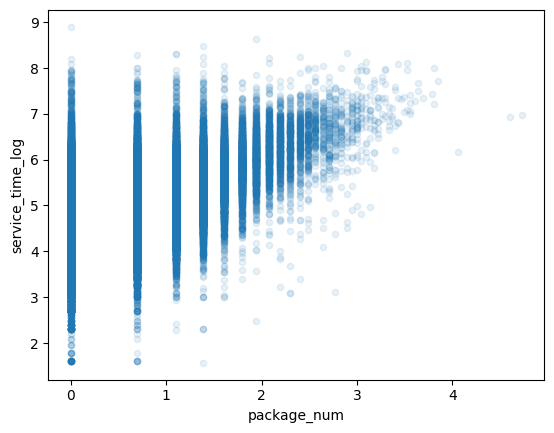

In [6]:
service_time_df.filter(pl.col("package_num").is_not_null()).with_columns(
    pl.col("package_num").log()
)[["package_num", "service_time_log", "city"]].to_pandas().plot.scatter(
    x="package_num",
    y="service_time_log",
    alpha=0.1,
)

<Axes: xlabel='volume', ylabel='service_time_log'>

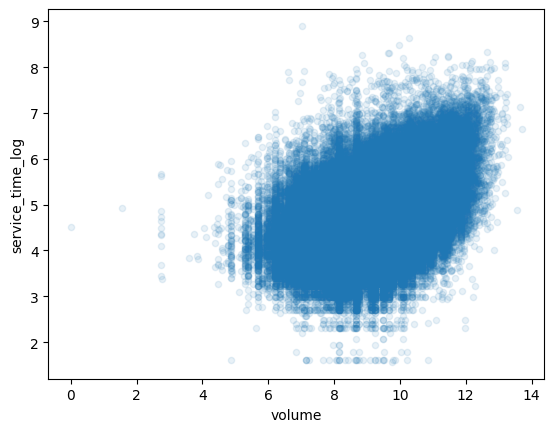

In [7]:
service_time_df.filter(pl.col("volume").is_not_null()).with_columns(
    pl.col("volume").log()
)[["volume", "service_time_log", "city"]].to_pandas().plot.scatter(
    x="volume",
    y="service_time_log",
    alpha=0.1,
)

## Load the Embeddings


In [8]:
embedding_df = pl.read_parquet(config.GeoVex.embedding_file)

embedding_df = embedding_df.join(
    service_time_df, left_on="region_id", right_on="region_id", how="inner"
)

## Load the Regression Model

using XGBoost


In [15]:
from typing import List
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import RobustScaler
from functime.preprocessing import scale

# min max scale the embedding


def train_xgb(df, target_col, feature_cols, **kwargs):
    model = XGBRegressor(**kwargs)
    model.fit(df[feature_cols].to_numpy(), df[target_col].to_numpy())
    return model


def predict_xgb(model, df, target_col, feature_cols):
    df = df.with_columns(
        [
            pl.Series(
                f"predicted_{target_col}", model.predict(df[feature_cols].to_numpy())
            )
        ]
    )
    return df


def split_test_train(
    df: pl.DataFrame,
    feature_cols,
    target_col,
    train_regions: List[str] = None,
    test_regions: List[str] = None,
    test_size=0.2,
):
    unique_regions = df["region_id"].unique()
    # split the unique regions into train and test
    if train_regions is None and test_regions is None:
        train_regions, test_regions = train_test_split(
            unique_regions, test_size=test_size
        )

    # create the tranformer
    # transformer = scale()
    # embedding_transformer = scale()

    train_df = (
        df.filter(pl.col("region_id").is_in(train_regions)).clone().with_row_count()
    )
    # train_df = train_df.update(
    #     train_df.select(target_col).pipe(transformer).collect(), on="row_nr"
    # ).update(
    #     train_df.select(feature_cols).pipe(embedding_transformer).collect(), on="row_nr"
    # )

    test_df = (
        df.filter(pl.col("region_id").is_in(test_regions))
        .group_by("region_id")
        .agg(
            pl.col(target_col).mean().alias(f"{target_col}"),
            pl.col(feature_cols).first(),
        )
        .clone()
        # .pipe(transformer)
        # .collect()
    )

    return train_df, test_df


def split_test_train_city(
    df: pl.DataFrame,
    feature_cols,
    target_col,
    train_cities: List[str] = None,
    test_cities: List[str] = None,
    city_col="city",
    *args,
    **kwargs,
) -> (pl.DataFrame, pl.DataFrame):
    train_df = df.filter(pl.col(city_col).is_in(train_cities)).clone()
    test_df = df.filter(pl.col(city_col).is_in(test_cities)).clone()

    test_df = test_df.group_by("region_id").agg(
        pl.col(target_col).mean().alias(f"{target_col}"),
        pl.col(feature_cols).first(),
    )

    return train_df, test_df


def score(df, true_col, pred_col):
    return r2_score(df[true_col], df[pred_col])


def train_test_xgb(
    df,
    target_col,
    feature_cols,
    train_regions=None,
    test_regions=None,
    split_fn=split_test_train,
    split_fn_kwargs={},
    **kwargs,
):
    train_df, test_df = split_fn(
        df,
        feature_cols,
        target_col,
        train_regions=train_regions,
        test_regions=test_regions,
        **split_fn_kwargs,
    )

    model = train_xgb(train_df, target_col, feature_cols, **kwargs)
    test_df = predict_xgb(model, test_df, target_col, feature_cols)
    # test_df = test_df.with_columns(
    #     pl.col('predicted_service_time_log').exp().alias('predicted_service_time'),
    #     pl.col('service_time_log').exp().alias('service_time')
    # )
    r2 = score(test_df, target_col, f"predicted_{target_col}")
    print(f"R2: {r2}")
    return r2

In [16]:
from sklearn.model_selection import KFold


def cv_folds(df, target_col, feature_cols, n_splits=5, **kwargs):
    # get the unique regions
    unique_regions = df["region_id"].unique().to_list()
    # create the folds
    kf = KFold(n_splits=n_splits)
    scores = []
    for train_index, val_index in kf.split(unique_regions):
        train_regions = [unique_regions[i] for i in train_index]
        val_regions = [unique_regions[i] for i in val_index]
        r2 = train_test_xgb(
            df,
            target_col,
            feature_cols,
            train_regions=train_regions,
            test_regions=val_regions,
            **kwargs,
        )

        scores.append(r2)
    avg_score = sum(scores) / len(scores)
    print(f"Average R2 score across {n_splits} folds: {avg_score}")
    return avg_score

In [11]:
embedding_df = pl.read_parquet(config.GeoVex.embedding_file)


embedding_df = embedding_df.join(
    service_time_df, left_on="region_id", right_on="region_id", how="inner"
)
# .with_columns(
#     pl.col("package_num").log(), pl.col("volume").log()
# )

for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
    print(f"---------- Training for {city} ------------")

    city_df = city_df.filter(pl.col("h3_count") >= 20)

    cv_folds(city_df, "service_time_log", list(map(str, range(50))), n_splits=5)

---------- Training for Brussels, Belgium ------------
R2: -0.2511014197994912
R2: -3.546471201733855
R2: -1.376860020791013
R2: -0.28395148213266297
R2: 0.12549777745414648
Average R2 score across 5 folds: -1.066577269400575
---------- Training for London, UK ------------
R2: -0.15349100953799022
R2: -0.6792554458715874
R2: -0.2903542728884565
R2: 0.07976930592018971
R2: -0.32757363626898317
Average R2 score across 5 folds: -0.27418101172936554
---------- Training for Boston, USA ------------
R2: 0.7057057401675663
R2: 0.7268990235902775
R2: 0.5688947848957593
R2: 0.6386028839487343
R2: 0.5408438496497691
Average R2 score across 5 folds: 0.6361892564504212
---------- Training for Seattle, USA ------------
R2: 0.6305228099819831
R2: 0.3611893188695098
R2: 0.5637782341303945
R2: 0.5365877229639473
R2: 0.5004353348467308
Average R2 score across 5 folds: 0.5185026841585131
---------- Training for Austin, USA ------------
R2: 0.2293352479467995
R2: 0.3845246649524937
R2: 0.2490144980135255

In [12]:
# embedding_df = pl.read_parquet(
#     ROOT / "data/geovex/embeddings_100_epochs_shuffled.parquet"
# )
embedding_files = list((ROOT / "data" / "geovex").glob("embeddings*parquet"))

scores = []

for embedding_file in embedding_files:
    print(f"Training for {embedding_file}")
    embedding_df = pl.read_parquet(embedding_file)

    cols = embedding_df.drop(["region_id"]).columns

    embedding_df = embedding_df.join(
        service_time_df, left_on="region_id", right_on="region_id", how="inner"
    )

    for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
        print(f"---------- Training for {city} ------------")

        city_df = city_df.filter(pl.col("h3_count") >= 5)

        res = cv_folds(city_df, "service_time_log", cols, n_splits=5)

        scores.append(
            {
                "embedding_file": embedding_file.stem,
                "city": city,
                "score": res,
            }
        )

        print(f"Score: {res}")

Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_validation_stop.parquet
---------- Training for Brussels, Belgium ------------
R2: -0.27953666582993963
R2: -0.4993987064287113
R2: -0.5405353036860545
R2: -0.036019149049357546
R2: -0.029391116269325668
Average R2 score across 5 folds: -0.2769761882526777
Score: -0.2769761882526777
---------- Training for London, UK ------------
R2: -0.35621143639159447
R2: -0.1294640550988264
R2: -0.23270084932835955
R2: -0.029716703783634557
R2: -0.1743312949954703
Average R2 score across 5 folds: -0.18448486791957705
Score: -0.18448486791957705
---------- Training for Boston, USA ------------
R2: 0.37659268685035907
R2: 0.40379103460832766
R2: 0.4981542074367279
R2: 0.5647282874674531
R2: 0.4878926263773845
Average R2 score across 5 folds: 0.46623176854805043
Score: 0.46623176854805043
---------- Training for Seattle, USA ------------
R2: 0.27899212859971323
R2: 0.20258982019352967
R2: 0.35622055904895544

In [13]:
# embedding_df = pl.read_parquet(
#     ROOT / "data/geovex/embeddings_100_epochs_shuffled.parquet"
# )
embedding_files = list((ROOT / "data" / "geovex").glob("embeddings*parquet"))

scores = []

for embedding_file in embedding_files:
    print(f"Training for {embedding_file}")
    embedding_df = pl.read_parquet(embedding_file)

    cols = embedding_df.drop(["region_id"]).columns

    embedding_df = embedding_df.join(
        service_time_df, left_on="region_id", right_on="region_id", how="inner"
    ).with_columns((pl.col("city").str.contains("USA").cast(float)).alias("van"))

    # for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
    # print(f"---------- Training for {city} ------------")
    city = "all"

    city_df = embedding_df.filter(pl.col("h3_count") >= 20)

    res = cv_folds(city_df, "service_time_log", cols + ["van"], n_splits=5)

    scores.append(
        {
            "embedding_file": embedding_file.stem,
            "city": city,
            "score": res,
        }
    )

    print(f"Score: {res}")

Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_validation_stop.parquet
R2: 0.511368446322332
R2: 0.5310326114931223
R2: 0.4823235009932958
R2: 0.5293953769808699
R2: 0.4668815087659278
Average R2 score across 5 folds: 0.5042002889111096
Score: 0.5042002889111096
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_100_epochs_shuffled.parquet
R2: 0.505999656940823
R2: 0.5877040654995582
R2: 0.547183399681928
R2: 0.5014202753266814
R2: 0.5571820116929873
Average R2 score across 5 folds: 0.5398978818283956
Score: 0.5398978818283956
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_shuffled.parquet
R2: 0.49100972218614725
R2: 0.4810835906189658
R2: 0.4669596838980823
R2: 0.4462022398800126
R2: 0.5171262227254507
Average R2 score across 5 folds: 0.48047629186173174
Score: 0.48047629186173174
Training for /Users/max/Development/green-last-mile/cargo-bike-anal

In [19]:
# embedding_df = pl.read_parquet(
#     ROOT / "data/geovex/embeddings_100_epochs_shuffled.parquet"
# )
embedding_files = list((ROOT / "data" / "geovex").glob("embeddings*parquet"))

scores = []

for embedding_file in embedding_files:
    print(f"Training for {embedding_file}")
    embedding_df = pl.read_parquet(embedding_file)

    cols = embedding_df.drop(["region_id"]).columns

    embedding_df = embedding_df.join(
        service_time_df, left_on="region_id", right_on="region_id", how="inner"
    ).with_columns((pl.col("city").str.contains("USA").cast(float)).alias("van"))

    # for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
    # print(f"---------- Training for {city} ------------")
    city = "all"

    city_df = embedding_df.filter(pl.col("h3_count") >= 10)

    res = train_test_xgb(
        city_df,
        "service_time_log",
        cols + ["van"],
        split_fn=split_test_train_city,
        split_fn_kwargs={
            "city_col": "city",
            "test_cities": ["Boston, USA"],
            "train_cities": ["Chicago, USA", "Seattle, USA", "Austin, USA", "London, UK", "Brussels, Belgium"],
        },
    )

    scores.append(
        {
            "embedding_file": embedding_file.stem,
            "city": city,
            "score": res,
        }
    )

    print(f"Score: {res}")

Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_validation_stop.parquet
R2: 0.11080146838529747
Score: 0.11080146838529747
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_100_epochs_shuffled.parquet
R2: 0.26823104382692486
Score: 0.26823104382692486
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_shuffled.parquet
R2: 0.07603831178231413
Score: 0.07603831178231413
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_500_randomized.parquet
R2: 0.15438230035136724
Score: 0.15438230035136724
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings.parquet
R2: 0.43344820867063005
Score: 0.43344820867063005
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_3_layers.parquet
R2: 0.07866358297300946
Score: 0.07866358297300946
Trainin

In [20]:
# embedding_df = pl.read_parquet(
#     ROOT / "data/geovex/embeddings_100_epochs_shuffled.parquet"
# )
embedding_files = list((ROOT / "data" / "geovex").glob("embeddings*parquet"))

scores = []

for embedding_file in embedding_files:
    print(f"Training for {embedding_file}")
    embedding_df = pl.read_parquet(embedding_file)

    cols = embedding_df.drop(["region_id"]).columns

    embedding_df = embedding_df.join(
        service_time_df, left_on="region_id", right_on="region_id", how="inner"
    ).with_columns((pl.col("city").str.contains("USA").cast(float)).alias("van"))

    # for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
    # print(f"---------- Training for {city} ------------")
    city = "all"

    city_df = embedding_df.filter(pl.col("h3_count") >= 10)

    res = train_test_xgb(
        city_df,
        "service_time_log",
        cols + ["van"],
        split_fn=split_test_train_city,
        split_fn_kwargs={
            "city_col": "city",
            "test_cities": ["London, UK"],
            "train_cities": ["Chicago, USA", "Seattle, USA", "Austin, USA", "Boston, USA", "Brussels, Belgium"],
        },
    )

    scores.append(
        {
            "embedding_file": embedding_file.stem,
            "city": city,
            "score": res,
        }
    )

    print(f"Score: {res}")

Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_validation_stop.parquet
R2: -2.5547268230876794
Score: -2.5547268230876794
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_100_epochs_shuffled.parquet
R2: -2.4361665834124033
Score: -2.4361665834124033
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_shuffled.parquet
R2: -0.8531775097157739
Score: -0.8531775097157739
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_500_randomized.parquet
R2: -1.598834231563555
Score: -1.598834231563555
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings.parquet
R2: -3.5127714710161264
Score: -3.5127714710161264
Training for /Users/max/Development/green-last-mile/cargo-bike-analysis/data/geovex/embeddings_3_layers.parquet
R2: -3.021362871743988
Score: -3.021362871743988
Training fo

In [14]:
score_df = pl.DataFrame(scores)

score_df.filter(pl.col("city").str.contains("Chicago")).sort(
    "score", descending=True
).to_pandas()

,embedding_file,city,score
0,embeddings_32_100_random,"Chicago, USA",0.575436
1,embeddings,"Chicago, USA",0.569161
2,embeddings_cropped,"Chicago, USA",0.546951
3,embeddings_500_randomized,"Chicago, USA",0.536837
4,embeddings_100_shuffled_lr,"Chicago, USA",0.520879
5,embeddings_validation_stop,"Chicago, USA",0.508316
6,embeddings_3_layers,"Chicago, USA",0.493336
7,embeddings_validation_stop_no_shuffle,"Chicago, USA",0.491279
8,embeddings_100_epochs_shuffled,"Chicago, USA",0.487760
9,embeddings_shuffled,"Chicago, USA",0.455544


In [16]:
score_df = pl.DataFrame(scores)

score_df.filter(pl.col("city").str.contains("Austin")).sort(
    "score", descending=True
).to_pandas()

,embedding_file,city,score
0,embeddings_32_100_random,"Austin, USA",0.377229
1,embeddings_500_randomized,"Austin, USA",0.298685
2,embeddings_100_shuffled_lr,"Austin, USA",0.292500
3,embeddings,"Austin, USA",0.262335
4,embeddings_cropped,"Austin, USA",0.262262
5,embeddings_shuffled,"Austin, USA",0.206924
6,embeddings_100_epochs_shuffled,"Austin, USA",0.196235
7,embeddings_validation_stop,"Austin, USA",0.147316
8,embeddings_validation_stop_no_shuffle,"Austin, USA",0.143405
9,embeddings_3_layers,"Austin, USA",0.116507


In [21]:
# embedding_df = pl.read_parquet(ROOT / "data/geovex/embeddings_validation_stop.parquet")


# embedding_df = embedding_df.join(
#     service_time_df, left_on="region_id", right_on="region_id", how="inner"
# )

# for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
#     print(f"---------- Training for {city} ------------")

#     city_df = city_df.filter(pl.col("h3_count") >= 20)

#     cv_folds(city_df, "service_time_log", list(map(str, range(50))), n_splits=5)

## Try with Population Data and Meta Tags


In [13]:
import src.urban_tools as ut

In [14]:
pop_df = pd.concat(
    [gpd.read_parquet(city.pop_file) for city in config.Cities], axis=0
).drop(columns=["geometry"])
pop_df.head()

count_df_file = ROOT / "data" / "geovex" / "count.parquet"
count_df = pl.read_parquet(count_df_file)
count_df = count_df.rename({"region_id": "h3"})

osm_category_df = ut.map_tags_to_categories(count_df.to_pandas())

Tags mapped to 'Other': []
Unmatched columns: set()


In [15]:
add_features = osm_category_df.columns.difference({"city", "h3"})

embedding_df = pl.read_parquet(ROOT / "data/geovex/embeddings.parquet")

embedding_df = embedding_df.join(
    service_time_df, left_on="region_id", right_on="region_id", how="inner"
)

embedding_df = embedding_df.join(
    pl.from_pandas(osm_category_df).drop("city"),
    left_on="region_id",
    right_on="h3",
    how="inner",
)

In [16]:
for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
    print(f"---------- Training for {city} ------------")

    city_df = city_df.filter(pl.col("h3_count") >= 5)

    cv_folds(
        city_df,
        "service_time",
        list(map(str, range(50))) + list(add_features),
        n_splits=5,
    )

---------- Training for Brussels, Belgium ------------
R2: -0.18534529247250098
R2: -0.07942546602484413
R2: -0.22722712016280266
R2: -0.2610959033460327
R2: -0.17721413284051657
Average R2 score across 5 folds: -0.18606158296933942
---------- Training for London, UK ------------
R2: -0.21447323110612326
R2: -0.19148356400409394
R2: -0.10391840114522011
R2: -0.06964422306936768
R2: -0.24595114055688527
Average R2 score across 5 folds: -0.16509411197633805
---------- Training for Boston, USA ------------
R2: 0.5914571131553379
R2: 0.4266426870317258
R2: 0.16982011524521068
R2: -0.04427748169817325
R2: 0.5719640839485156
Average R2 score across 5 folds: 0.34312130353652337
---------- Training for Seattle, USA ------------
R2: 0.3443730770431468
R2: 0.4161005595396926
R2: 0.3868345131979066
R2: 0.31973266869159944
R2: 0.28760883613405974
Average R2 score across 5 folds: 0.35092993092128105
---------- Training for Austin, USA ------------
R2: 0.1995115620132183
R2: 0.2297455571514444
R2: 0

In [17]:
# embedding_df = pl.read_parquet(
#     "/Users/max/Development/green-last-mile/cargo-bike-analysis/notebooks/embeddings/wandb/run-20231021_192850-l22kqmz6/files/embeddings.parquet"
# )

# embedding_df = embedding_df.join(
#     service_time_df, left_on="region_id", right_on="h3", how="inner"
# )

# for city, city_df in embedding_df.partition_by("city", as_dict=True).items():
#     print(f"---------- Training for {city} ------------")

#     city_df = city_df.filter(pl.col("h3_count") >= 20)

#     model, test_df = train_test_xgb(
#         city_df,
#         target_col="service_time_log",
#         feature_cols=list(map(str, range(50))),
#     )